
# <font color='white'>Projeto Análise de Sentimento</font>



## <font color='white'>Instalação dos pacotes</font>


In [143]:
!pip install -q -U watermark

In [144]:
!pip install tensorflow

In [145]:
!pip install -q spacy

In [146]:
!pip install -q transformers


## <font color='white'>Imports</font>


In [198]:
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import load_model
from keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.callbacks import EarlyStopping, LearningRateScheduler,CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers.experimental import Adam



## <font color='white'>Carregando dados</font>


In [148]:
#Dados Treino
dados_dsa_treino = pd.read_csv('C:\\Users\\Danilo\\OneDrive\\Documentos\\Engenheiro_IA\\Projeto_Class_Sentimento\\dados_treino.txt', header = None,delimiter = ';')

In [149]:
#Dados Teste
dados_dsa_teste = pd.read_csv('C:\\Users\\Danilo\\OneDrive\\Documentos\\Engenheiro_IA\\Projeto_Class_Sentimento\\dados_teste.txt', header = None,delimiter = ';')

In [150]:
#Ajusta nomes colunas
dados_dsa_treino = dados_dsa_treino.rename(columns = {0: 'texto', 1:'sentimento'})
dados_dsa_teste = dados_dsa_teste.rename(columns = {0: 'texto', 1:'sentimento'})

In [151]:
dados_dsa_treino.shape

(16000, 2)

In [152]:
dados_dsa_teste.shape

(2000, 2)

In [153]:
dados_dsa_treino.head()

,texto,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [154]:
dados_dsa_teste.head()

,texto,sentimento
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [155]:
dados_dsa_treino['sentimento'].value_counts()

sentimento
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [156]:
dados_dsa_teste['sentimento'].value_counts()

sentimento
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64


### <font color='white'>Pré Processamento</font>


In [157]:
!python -m spacy download en_core_web_md -q

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [158]:
dsa_nlp = spacy.load('en_core_web_md')

In [159]:
# Definição da função 'dsa_preprocessa_texto' que recebe um texto como parâmetro
def dsa_preprocessa_texto(text):
    doc = dsa_nlp(text)
    tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
    return ' '.join(tokens)

In [160]:
dados_dsa_treino['texto_processado'] = dados_dsa_treino['texto'].apply(dsa_preprocessa_texto)

In [161]:
dados_dsa_teste['texto_processado'] = dados_dsa_teste['texto'].apply(dsa_preprocessa_texto)

In [162]:
dados_dsa_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...



### <font color='white'>Vetorização com TF-IDF</font>


In [163]:
dsa_tfidf = TfidfVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')

Esta linha acima cria uma instância TfidVectorizer da biblioteca scikit-learn, que é uma ferramenta utilizada para converter uma coleção de documentos brutos em uma matriz de recursos TF-IDF (Term Frequency-Inverse Document Frequency). O TF-IDF é uma técnica estatística usada para quantificar a importância de uma palavra em um conjunto de documentos, comumente utilizada em tarefas de PLN e recuperação de informações.

Parâmetro max_df = 0.95: Este parâmetro define o limite máximo de frequência do documento para os termos que serão considerados. Aqui, está definido como 0.95, o que significa que palavras que aparecem em mais de 95% dos documentos serão ignoradas. Isso ajuda a eliminar palavras comuns que não contribuem muito para o significado do texto.

Parâmetro min_df = 2: Este parâmetro estabelece a frequência mínima de documento para os termos. Neste caso, termos que aparecem em menos de 2 documentos serão ignorados. Isso ajuda a filtrar termos raros que podem ocorrer apenas em poucas amostras e, portanto, são menos relevantes para a análise geral.

Parâmetro stop_words = 'english'. Este parâmetro instrui o vetorizador a remover todas as palavras de parada em inglês da análise. Palavras de parada são palavras comuns (como "e", "o", "em") que geralmente são filtradas em processamento de linguagem natural porque são muito frequentes e não carregam informações significativas para análise do texto.

In [188]:
# Aplica o vetorizador
dados_treino_tfidf = dsa_tfidf.fit_transform(dados_dsa_treino['texto_processado'])
dados_teste_tfidf = dsa_tfidf.transform(dados_dsa_teste['texto_processado'])

In [165]:
dados_treino_tfidf.shape

(16000, 5586)

In [166]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [189]:
# Converte os dados de entrada (texto) para array
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()


### <font color='white'>Preparação dos Dados</font>


In [168]:
dsa_le = LabelEncoder()

In [169]:
y_treino_le = dsa_le.fit_transform(dados_dsa_treino['sentimento'])

In [170]:
y_teste_le = dsa_le.fit_transform(dados_dsa_teste['sentimento'])

Vamos tratar de forma automática o desbalanceamento da base

In [171]:
#Peso das classes 
pesos_classes = compute_class_weight('balanced', classes = np.unique(y_treino_le), y = y_treino_le)

In [172]:
type(pesos_classes)

numpy.ndarray

compute_class_weight: Esta é uma função do sikit-learn que calcula os pesos para as classes. Esses pesos podem ser usados em modelos de classificação para dar maior importância a classes que são sub-representadas no conjunto de dados.

'balanced': Este parâmetro indica que os pesos das classes devem ser calculados de forma que equilibrem o conjunto de dados. Isso é feito inversamente proporcional à frequência das classes no conjunto de dados. Classes mais frequentes recebem um peso menor, enquanto classes menos frequentes recebem um peso maior.

classes = np.unique(y_treino_le): Aqui , np.unique(y_treino_le) encontra todas as classes únicas no conjunto de dados de treinamento. O parâmetro classe informa á função compute_class_weight quais são essas classes únicas.

y = y_treino_le: Este é o vetor de rótulos do conjunto de treinamento. A função usará esses rótulos para calcular a frequência de cada classe. O resultado, armazenado em pesos_classes, é um array onde cada classe tem um peso associado. Esses pesos podem ser usados em modelos de classificação (como uma árvore de decisão, um modelo de regressão logística, SVM, etc.) para compensar o desequilíbrio entre as classes.

In [173]:
# Divisão em Dados de Treino e Validação
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array,
                                                    y_treino_le,
                                                    test_size = 0.2,
                                                    random_state = 42,
                                                    stratify = y_treino_le)

In [174]:
# Ajusta a target como tipo categorical
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)

In [175]:
# Shape
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))


### <font color='white'>Construção do Modelo</font>


In [176]:
modelo_dsa_v1 = Sequential()

modelo_dsa_v1.add(Dense(4096,
                       activation = 'selu',
                       kernel_initializer = 'lecun_normal',
                       input_shape = (X_treino.shape[1],),
                       kernel_regularizer = tf.keras.regularizers.l2(0.01)))

modelo_dsa_v1.add(Dense(2048,
                       activation = 'selu',
                       kernel_initializer = 'lecun_normal',
                       kernel_regularizer = tf.keras.regularizers.l2(0.01)))

modelo_dsa_v1.add(Dense(1024,
                       activation = 'selu',
                       kernel_initializer = 'lecun_normal',
                       kernel_regularizer = tf.keras.regularizers.l2(0.1)))


modelo_dsa_v1.add(Dense(64, activation = 'selu',))

modelo_dsa_v1.add(Dense(6, activation = 'softmax',))


### <font color='white'>Compilação e Sumário</font>


In [177]:
#Esta parte diz ao modelo para utilizar um peso um pouco maior as classes minoritárias
modelo_dsa_v1.layers[-1].bias.assign(pesos_classes)

<tf.Variable 'UnreadVariable' shape=(6,) dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [178]:
modelo_dsa_v1.compile(optimizer = 'Adam',
                     loss = tf.losses.categorical_crossentropy,
                     metrics = ['accuracy'])

In [179]:
modelo_dsa_v1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 4096)              22884352  
                                                                 
 dense_16 (Dense)            (None, 2048)              8390656   
                                                                 
 dense_17 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_18 (Dense)            (None, 64)                65600     
                                                                 
 dense_19 (Dense)            (None, 6)                 390       
                                                                 
Total params: 33439174 (127.56 MB)
Trainable params: 33439174 (127.56 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________



### <font color='white'>Callbacks e Early Stopping</font>


In [180]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+ epoch)/epochs_drop))
    return lrate

In [181]:
lr_scheduler = LearningRateScheduler(step_decay)

In [182]:
early_stopping = EarlyStopping(monitor = 'val_loss', restore_best_weights = True, patience = 3)


### <font color='white'>Treinamento</font>


In [183]:
num_epochs = 20
tamanho_batch = 256

In [184]:
%%time
history = modelo_dsa_v1.fit(X_treino,
                           y_treino_encoded,
                           validation_data = (X_val, y_val_encoded),
                           epochs = num_epochs,
                           batch_size = tamanho_batch,
                           callbacks = [early_stopping, lr_scheduler])

Epoch 1/20
50/50 [==============================] - 37s 725ms/step - loss: 36.9259 - accuracy: 0.6749 - val_loss: 2.2872 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 39s 772ms/step - loss: 1.4881 - accuracy: 0.8040 - val_loss: 1.2814 - val_accuracy: 0.8072 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 38s 754ms/step - loss: 1.2125 - accuracy: 0.8235 - val_loss: 1.2637 - val_accuracy: 0.7919 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 39s 772ms/step - loss: 1.0610 - accuracy: 0.8548 - val_loss: 1.0853 - val_accuracy: 0.8356 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 39s 771ms/step - loss: 0.9585 - accuracy: 0.8784 - val_loss: 1.1265 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 38s 769ms/step - loss: 0.9363 - accuracy: 0.8932 - val_loss: 1.1068 - val_accuracy: 0.8353 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 38s 753ms/s

### <font color='white'>Avaliação do Modelo</font>

In [185]:
loss, val_loss = history.history['loss'], history.history['val_loss']

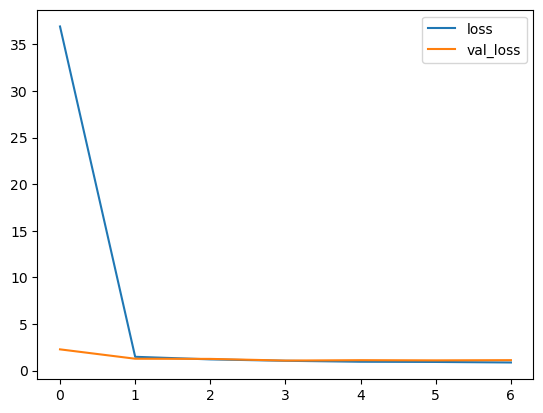

In [186]:
plt.plot(loss, label = 'loss')
plt.plot(val_loss, label = 'val_loss')
plt.legend()
plt.show()

### <font color='white'>Previsões com dados de teste</font>

In [190]:
previsoes_v1 = modelo_dsa_v1.predict(X_teste_array)

63/63 [==============================] - 3s 45ms/step


In [191]:
previsoes_v1_labels = previsoes_v1.argmax(axis = 1)

In [192]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.84      0.77      0.80       275
           1       0.77      0.85      0.81       224
           2       0.89      0.88      0.88       695
           3       0.69      0.70      0.70       159
           4       0.85      0.90      0.87       581
           5       0.90      0.41      0.56        66

    accuracy                           0.84      2000
   macro avg       0.82      0.75      0.77      2000
weighted avg       0.84      0.84      0.84      2000



In [193]:
print(confusion_matrix(y_teste_le, previsoes_v1_labels))

[[213  12  18   0  32   0]
 [  9 190   5   0  19   1]
 [  9   7 610  39  30   0]
 [  3   1  30 112  12   1]
 [ 20  13  16   7 524   1]
 [  1  25   7   4   2  27]]


In [195]:
print(accuracy_score(y_teste_le, previsoes_v1_labels))

0.838


In [196]:
modelo_dsa_v1.save('modelo_dsa_v1.keras')

### <font color='white'>Deploy da Versão 1 do Modelo</font>

In [199]:
modelo = load_model('modelo_dsa_v1.keras')

In [200]:
#Nova frase (sentimento = fear)
frase = "i even fell a little shaky"

In [201]:
#cria um df com a frase
df_novo = pd.DataFrame({'Frase': [frase]})

In [204]:
#Aplica a função de processamento
df_novo['Frase_Processada'] = df_novo['Frase'].apply(dsa_preprocessa_texto) 

In [205]:
df_novo

,Frase,Frase_Processada
0,i even fell a little shaky,fall little shaky


In [207]:
#Aplica a vetorização
df_novo_tfidf = dsa_tfidf.transform(df_novo['Frase_Processada'])

In [208]:
#Transforma em array
df_novo_array = df_novo_tfidf.toarray()

In [209]:
previsoes = modelo.predict(df_novo_array)

1/1 [==============================] - 0s 104ms/step


In [210]:
previsoes

array([[8.9615444e-03, 9.4486076e-01, 6.5378030e-03, 2.8900744e-04,
        8.7002814e-03, 3.0650536e-02]], dtype=float32)

In [211]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = np.argmax(previsoes, axis = 1)

In [212]:
classe_maior_prob

array([1], dtype=int64)

In [213]:
# Obtém o nome da classe
nome_classe = dsa_le.inverse_transform(classe_maior_prob)

In [214]:
# Classe prevista
nome_classe

array(['fear'], dtype=object)